# Load the Lung Cancer Data:
Features considered:
- Smoker: Current Smoker, Previous Smoker, Non-smoker
- Gender: Man, Woman
- Age: Young($\leq$ 50), Old(>50)
- Mutation: 
- Family: 
- Cancer: 
- Treatment: 
- Stage: 
- Relapse: 

In [77]:
import copy
def clean_df(df_in):
    df = copy.deepcopy(df_in)
    original_feature_names = ["EHR","AgeCategory","Gender", "Smoking_habits", "Stages","Drug","familyType","CancerType","Biomarker","Relapse"]
    new_feature_names = ["Patient_id", 'Age', "Gender", "Smoker", "Stage", "Treatment", "Family", "Cancer", "Mutation", "Relapse"]
    
    df.rename(columns = dict(zip(original_feature_names, new_feature_names)), inplace = True)
    
    df.replace('\s+','',regex=True,inplace=True) 
    for feature in new_feature_names:
        if feature not in df.head().columns:
            continue
        df[feature] = df[feature].str.replace("http://clarify2020.eu/entity/", '')
    return df


def standardize_df(df_in):
    df = copy.deepcopy(df_in)
    

In [82]:
import pandas as pd
import matplotlib.pyplot as plt
df = pd.read_csv("sparql.csv")
df = clean_df(df)

for feature in df.head().columns:
    if "Patient" in feature:
        continue
    print(feature, '\t', list(set(df[feature].values)))

print(df.head())
# df = standardize_df(df)
# print("dataset with cigarette", len(df))


Age 	 ['OLDER', 'YOUNGER']
Gender 	 ['Female', 'Male']
Stage 	 ['Otros', 'IVB', 'IIA', 'IIB', 'IIIA', 'IIIC', 'IB', 'IVA', 'IA1', 'IA', 'I', 'Extendido', 'IA3', 'II', 'IIIB', 'Limitado', 'III', 'IV', 'IA2']
Treatment 	 ['Avelumab', 'Denosumab', 'Antiangiogenic_(blind_clinical_trial)', 'Ramucirumab', 'Mesna', 'Erlotinib', 'Durvalumab_(MEDI4736)', 'Xentuzumab', 'Veliparib_(ABT-_888)', 'Emactuzumab_(RG7155)', 'Onartuzumab_(MetMAb)', 'Nazartinib', 'Ipilimumab', 'Nivolumab', 'Nab-Paclitaxel', 'Galunisertib', 'Carboplatin', 'Rociletinib', 'Trabectedin', 'Ceritinib', '5-Fluorouracil', 'Crizotinib', 'Bevacizumab', 'Azacitidine', 'Pembrolizumab', 'Oxaliplatin', 'Ganetespib', 'Anetumab', 'Abemaciclib', 'Cisplatin', 'Onartuzumab_(MetMAb)_vs_Placebo', 'Lorlatinib', 'Vinorelbine', 'Canakinumab', 'Trametinib', 'Alisertib', 'AMG', 'Rovalpituzumab', 'Demcizumab', 'Bevacizumab_vs_Placebo', 'Vadimezan_(ASA404)_vs_Placebo', 'Cemiplimab', 'Afatinib', 'Dacomitinib', 'Octreotide', 'Tiragolumab', 'Bavituxima

# Hypothetical Directed Acyclic Graph

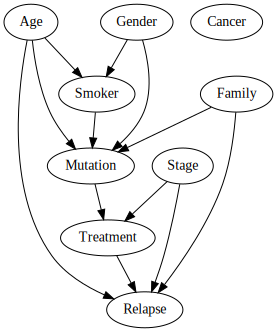

In [63]:
from graphviz import Digraph
# Create Digraph object
dot = Digraph()

# Nodes
dot.node('Smoker')
dot.node('Gender')
dot.node('Age')
dot.node('Mutation')
dot.node('Family')
dot.node('Cancer')
dot.node('Treatment')
dot.node('Stage')
dot.node('Relapse')

# Edges
lung_cancer_edges = [('Smoker', 'Mutation'), 
('Age', 'Smoker'), ('Age', 'Mutation'), ('Age', 'Relapse'),
('Gender', 'Smoker'), ('Gender', 'Mutation'),
('Mutation', 'Treatment'),
('Treatment', 'Relapse'),
('Family', 'Mutation'), ('Family', 'Relapse'),
('Stage', 'Treatment'), ('Stage', 'Relapse')]

for head, tail in lung_cancer_edges:
    dot.edge(head, tail)

# dot.edge('Cancer', )

dot


# Structure Learning or Definition

In [31]:
import bnlearn as bn

from itertools import combinations

import networkx as nx
from sklearn.metrics import f1_score

from pgmpy.estimators import PC, HillClimbSearch, ExhaustiveSearch
from pgmpy.estimators import K2Score
from pgmpy.utils import get_example_model
from pgmpy.sampling import BayesianModelSampling

import networkx as nx
import numpy as np
import matplotlib.pyplot as plt


import bnlearn as bn

def structure_learn_by_HC_search(data):
    
    # Structure learning
    model = bn.structure_learning.fit(data, methodtype='hc', scoretype='bdeu')
    
    # print(model['model_edges'])
    # print(model['config'])
    # print(model['adjmat'])
    
    # Compute edge strength using chi-square independence test
    model = bn.independence_test(model, data, alpha=0.05, prune=True)
    G = bn.plot(model)
    return model['model_edges']


def structure_learn_by_Constriant_search(data):
    # Structure learning
    model = bn.structure_learning.fit(data, methodtype='cs')    # 'cs':'constraintsearch' with score
    model = bn.independence_test(model, data, alpha=0.05)   # prune=true
    G = bn.plot(model)
    # print(model['independence_test'])
    return model['model_edges']

def casual_discovery_PC(data):
    from causallearn.search.ConstraintBased.PC import pc
    from causallearn.utils.cit import chisq, fisherz
    print(data.head().columns)
    # PC algorithm
    cg = pc(data.to_numpy(), alpha = 0.05, indep_test=fisherz, stable=True, uc_rule=0, uc_priority=1)

    edges = cg.G.get_graph_edges()
    X_nodes = cg.G.get_nodes()
    # print(cg.G.graph)
    nodes = data.head().columns
    for edge in edges:
        # print(edge.get_endpoint1())
        # print(edge.get_endpoint2())
        src_node = X_nodes.index(edge.get_node1())
        tar_node = X_nodes.index(edge.get_node2())
        print(edge.get_node1(), '-->', edge.get_node2(),'\t', nodes[src_node], '-->', nodes[tar_node])

    # visualization using pydot
    cg.draw_pydot_graph()

def hybrid_structure_learning(data):
    from pgmpy.estimators import MmhcEstimator
    from pgmpy.estimators import BDeuScore
    from pgmpy.estimators import HillClimbSearch

    mmhc = MmhcEstimator(data)
    skeleton = mmhc.mmpc(significance_level=0.05)
    print("Part 1) Skeleton: ", skeleton.edges())
    
    # use hill climb search to orient the edges:
    hc = HillClimbSearch(data)
    model = hc.estimate(scoring_method=BDeuScore(data), tabu_length=10, white_list=skeleton.to_directed().edges())
    print("Part 2) Model:    ", model.edges())
    model

def structure_defined():
    return lung_cancer_edges


# df = bn.import_example('asia')
# df = df[['xray', 'lung', 'smoke', 'bronc']]
# edges = structure_learn_by_HC(df)
# edges = structure_learn_by_Constriant_Based(df)

In [32]:
import pandas as pd

def digitalize(df):
    for col in df.columns:
        replace_dict = {val:i for i, val in enumerate(set(df[col].values))}
        print(replace_dict)
        df[col].replace(to_replace=replace_dict, inplace=True)
    return df

df = pd.read_csv('no_treatment3.csv')
df = digitalize(df)
df.drop(columns=['Relapse'], inplace=True)

structure_learn_by_Constriant_search(df)
# structure_learn_by_HC_search(df)
# casual_discovery_PC(df)
# hybrid_structure_learning(df)


{'OLDER': 0, 'YOUNGER': 1}
{'Male': 0, 'Female': 1}
{'IIIC': 0, 'IIIA': 1, 'IA': 2, 'I': 3, 'III': 4, 'IB': 5, 'IV': 6, 'IIIB': 7, 'IVB': 8, 'IA3': 9, 'UNK': 10, 'IVA': 11, 'IA1': 12, 'IA2': 13, 'II': 14, 'IIA': 15, 'IIB': 16}
{'Man': 0, 'No': 1, 'ManAndWoman': 2, 'Woman': 3}
{'BothCancer': 0, 'MajorCancer': 1, 'No': 2, 'MinorCancer': 3}
{'PreviousSmoker': 0, 'NonSmoker': 1, 'CurrentSmoker': 2}
{'Other': 0, 'ALKorEGFR': 1, 'No': 2}
{'No_progression': 0, 'Relapse': 1, 'Progression': 2}
{'3+': 0, '0': 1, '1': 2, '2': 3}
[bnlearn] >Computing best DAG using [ex]
[bnlearn] >Set scoring type at [bic]


KeyboardInterrupt: 

# Parameter Learning

In [16]:

def check_node_feature_names(edges, data):
    features = set(data.head().columns)
    node_names = set([node for node_pair in edges for node in node_pair])
    assert(not features.difference(node_names))

def paras_learn_by_bayes(edges, data):
    check_node_feature_names(edges, data)
    # Make the actual Bayesian DAG
    DAG = bn.make_DAG(edges, verbose=0, methodtype='bayes')
    model = bn.parameter_learning.fit(DAG, data, verbose=3, methodtype='bayes')
    bn.print_CPD(model)
    return model

def paras_learn_by_ML(edges, data):
    check_node_feature_names(edges, data)
    DAG = bn.make_DAG(edges, verbose=0, methodtype='bayes')
    # print(DAG)
    # print(set(data.head().columns))
    model = bn.parameter_learning.fit(DAG, data, methodtype='ml')
    bn.print_CPD(model)
    return model

edges = [('Cloudy', 'Sprinkler'),
         ('Cloudy', 'Rain'),
         ('Sprinkler', 'Wet_Grass'),
         ('Rain', 'Wet_Grass')]

# paras_learn_by_bayes(edges, df)
# paras_learn_by_ML(edges, df)



# Bayesian Network Learning

In [67]:
def bn_learn_by_data(data, structure_setting, para_settting):
    if structure_setting == 'cs':
        model = bn.structure_learning.fit(data, methodtype='cs')
    else:
        model = bn.structure_learning.fit(data, methodtype=structure_setting, scoretype='bic')
    # prune insignificant edges
    model = bn.independence_test(model, data, alpha=0.05, prune=True)
    model_bn = bn.parameter_learning.fit(model, df, methodtype=para_settting)  # maximum likelihood estimator
    return model_bn

def bn_defined():
    from pgmpy.factors.discrete import TabularCPD
    edges = structure_defined()
    DAG = bn.make_DAG(edges)
    # Cloudy
    cpt_cloudy = TabularCPD(variable='Cloudy', variable_card=2, values=[[0.3], [0.7]])
    print(cpt_cloudy)

    # Sprinkler
    cpt_sprinkler = TabularCPD(variable='Sprinkler', variable_card=2,
                            values=[[0.4, 0.9], [0.6, 0.1]],
                            evidence=['Cloudy'], evidence_card=[2])
    print(cpt_sprinkler)

    # Rain
    cpt_rain = TabularCPD(variable='Rain', variable_card=2,
                        values=[[0.8, 0.2], [0.2, 0.8]],
                        evidence=['Cloudy'], evidence_card=[2])
    print(cpt_rain)

    # Wet Grass
    cpt_wet_grass = TabularCPD(variable='Wet_Grass', variable_card=2,
                            values=[[1, 0.1, 0.1, 0.01],
                                    [0, 0.9, 0.9, 0.99]],
                            evidence=['Sprinkler', 'Rain'],
                            evidence_card=[2, 2])
    DAG = bn.make_DAG(DAG, CPD=[cpt_cloudy, cpt_sprinkler, cpt_rain, cpt_wet_grass])
    return DAG


In [ ]:
# Save model
bn.save(model, filepath='bnlearn_model', overwrite=True)
# Learn structure
model = bn.structure_learning.fit(df, methodtype='tan', class_node='lung')# Load model
model = bn.load(filepath='bnlearn_model')

# Inference

In [ ]:

query = bn.inference.fit(model, variables=['Grenn'], evidence={'Aemon': 1, 'Samwell': 1})



# Experiments

In [14]:
import pandas as pd
import copy

df = pd.read_csv("../Causal/Dataset7.csv")
df.replace(['0', '1'], [0, 1], inplace=True)

X = df.loc[(df.mutation != 'No')]
print(len(set(X.patient_id.values)))
X.drop_duplicates(keep='first', inplace=True)
# X.drop_duplicates(subset=['patient_id', 'cancer'], keep='first', inplace=True)

X = X[['gender', 'age', 'mutation', 'smoker', 'cancer']]

X['mutation'].replace(['ALK', 'EGFR', 'PDL1', 'No'], [1, 1, 0, 2], inplace=True)
X['gender'].replace(['F', 'M'], [0, 1], inplace=True)
X['age'].replace(['Young', 'Old'], [0, 1], inplace=True)
X['smoker'].replace(['N', 'P', 'C'], [0, 1, 2], inplace=True)
# Cancer Lung
X1 = copy.deepcopy(X)
X1['cancer'].replace([0, 'No', 'Lung', 'Breast', 'Colorrectal', 'UNK'], [0, 4, 1, 2, 3, 0], inplace=True)


df = X1
df.rename(columns={'cancer':'Cancer', 'age':'Age', 'gender':'Gender', 'mutation':'Mutation', 'smoker': 'Smoker'}, inplace=True)
df.head()

3241


,Gender,Age,Mutation,Smoker,Cancer
0,0,1,0,1,0
1,0,1,0,1,0
2,0,0,0,0,1
3,0,0,0,0,3
4,0,0,0,0,0


[bnlearn] >Computing best DAG using [cs]


Working for n conditional variables: 5: 100%|██████████| 5/5 [00:01<00:00,  4.90it/s]


[bnlearn] >Compute edge strength with [chi_square]
[bnlearn]> Set node properties.
[bnlearn]> Set edge weights based on the [chi_square] test statistic.
[bnlearn]> Set edge properties.
[bnlearn] >Plot based on Bayesian model


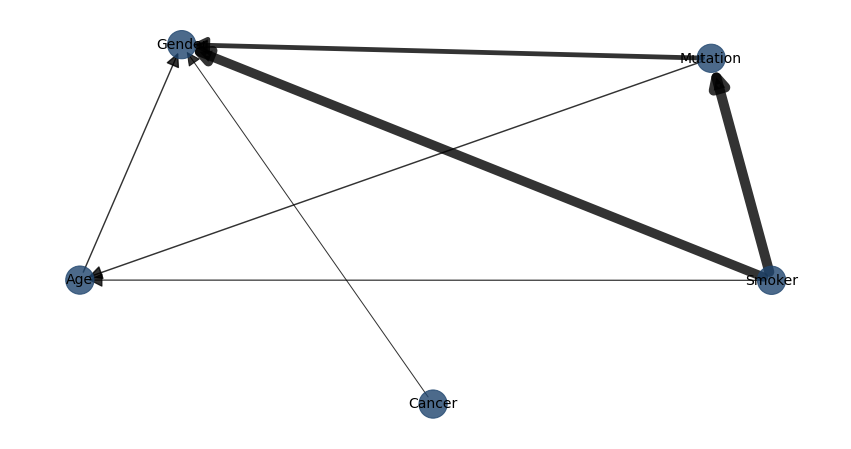

[bnlearn] >Parameter learning> Computing parameters using [bayes]
[bnlearn] >CPD of Mutation:
+-------------+---------------------+-----+---------------------+
| Smoker      | Smoker(0)           | ... | Smoker(2)           |
+-------------+---------------------+-----+---------------------+
| Mutation(0) | 0.34778780541492404 | ... | 0.787838511380628   |
+-------------+---------------------+-----+---------------------+
| Mutation(1) | 0.652212194585076   | ... | 0.21216148861937195 |
+-------------+---------------------+-----+---------------------+
[bnlearn] >CPD of Gender:
+-----------+--------------------+-----+--------------------+
| Age       | Age(0)             | ... | Age(1)             |
+-----------+--------------------+-----+--------------------+
| Cancer    | Cancer(0)          | ... | Cancer(4)          |
+-----------+--------------------+-----+--------------------+
| Mutation  | Mutation(0)        | ... | Mutation(1)        |
+-----------+--------------------+-----+------

In [17]:
# load numerical data
numeric_df = df

# learn structure
# structure1 = structure_defined()
structure2 = structure_learn_by_Constriant_Based(numeric_df)

# learn parameter
model2 = paras_learn_by_bayes(structure2, numeric_df)

# save or load
# bn.save(model, filepath='lung_cancer_bn.model', overwrite=True)
# model = bn.load(filepath='lung_cancer_bn.model')




In [21]:
# do inference on ["Patient_id", 'Age', "Gender", "Smoker", "Stage", "Treatment", "Family", "Cancer", "Mutation", "Relapse"]
bn_model = model2['model']


from pgmpy.inference import VariableElimination
from pgmpy.factors.discrete import TabularCPD

asia_infer = VariableElimination(bn_model)

lung_virt_evidence = TabularCPD(variable="Cancer", variable_card=5, values=[[0.7], [0.1], [0.0], [0.1], [0.1]])

q = asia_infer.query(variables=['Smoker'], evidence={'Mutation': 1}, virtual_evidence=[lung_virt_evidence])
print(q)

# 1. which subgroup is more likely if given patient has mutation ALK or EGFR
# query = bn.inference.fit(model, variables=['Smoker', 'Gender'], evidence={'Mutation': 1})
# 2. which cancer and family is more likely to have if given patient has mutation ALK or EGFR
# query = bn.inference.fit(model, variables=['Cancer'], evidence={'Mutation': 1})

Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]

+-----------+---------------+
| Smoker    |   phi(Smoker) |
+===========+===============+
| Smoker(0) |        0.4596 |
+-----------+---------------+
| Smoker(1) |        0.3423 |
+-----------+---------------+
| Smoker(2) |        0.1981 |
+-----------+---------------+


# Examples

[bnlearn] >Extracting files..


Generating for node: dysp: 100%|██████████| 8/8 [00:00<00:00, 128.54it/s]

[bnlearn]> Set node properties.
[bnlearn]> Set edge properties.
[bnlearn] >Plot based on Bayesian model


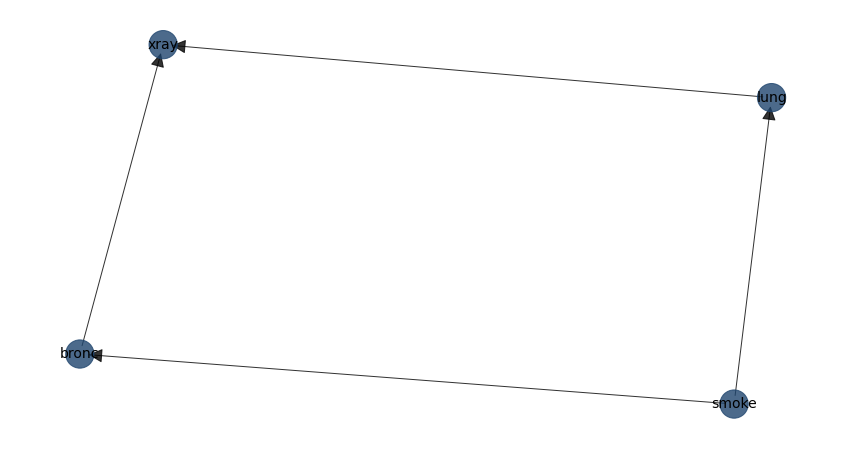

[bnlearn] >Removing columns from dataframe to make consistent with DAG [['asia' 'tub' 'either' 'dysp']]
[bnlearn] >Parameter learning> Computing parameters using [bayes]
[bnlearn] >CPD of smoke:
+----------+----------+
| smoke(0) | 0.493909 |
+----------+----------+
| smoke(1) | 0.506091 |
+----------+----------+
[bnlearn] >CPD of lung:
+---------+---------------------+---------------------+
| smoke   | smoke(0)            | smoke(1)            |
+---------+---------------------+---------------------+
| lung(0) | 0.14062212405669058 | 0.05478713849470092 |
+---------+---------------------+---------------------+
| lung(1) | 0.8593778759433094  | 0.945212861505299   |
+---------+---------------------+---------------------+
[bnlearn] >CPD of bronc:
+----------+--------------------+--------------------+
| smoke    | smoke(0)           | smoke(1)           |
+----------+--------------------+--------------------+
| bronc(0) | 0.5853119823302043 | 0.3245913418358182 |
+----------+------------

Generating for node: xray: 100%|██████████| 4/4 [00:00<00:00, 393.51it/s]


[bnlearn] >Variable Elimination..


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


+----+--------+-----------+
|    |   lung |         p |
+====+========+===========+
|  0 |      0 | 0.0547871 |
+----+--------+-----------+
|  1 |      1 | 0.945213  |
+----+--------+-----------+
[bnlearn] >Variable Elimination..


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


+----+--------+-----------+
|    |   lung |         p |
+====+========+===========+
|  0 |      0 | 0.0547871 |
+----+--------+-----------+
|  1 |      1 | 0.945213  |
+----+--------+-----------+
[bnlearn] >Variable Elimination..


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]

+----+---------+--------+----------+
|    |   bronc |   lung |        p |
+====+=========+========+==========+
|  0 |       0 |      0 | 0.113287 |
+----+---------+--------+----------+
|  1 |       1 |      0 | 0.229935 |
+----+---------+--------+----------+
|  2 |       0 |      1 | 0.218659 |
+----+---------+--------+----------+
|  3 |       1 |      1 | 0.438119 |
+----+---------+--------+----------+
[bnlearn] >Variable Elimination..



Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]

+----+---------+--------+----------+
|    |   bronc |   lung |        p |
+====+=========+========+==========+
|  0 |       0 |      0 | 0.35196  |
+----+---------+--------+----------+
|  1 |       1 |      0 | 0.243233 |
+----+---------+--------+----------+
|  2 |       0 |      1 | 0.240637 |
+----+---------+--------+----------+
|  3 |       1 |      1 | 0.164169 |
+----+---------+--------+----------+
['smoke', 'lung', 'bronc', 'xray']


,lung,bronc,p
0,0,0,0.351960
1,0,1,0.243233
2,1,0,0.240637
3,1,1,0.164169


In [70]:
df = bn.import_example('asia')
# from tabulate import tabulate
# print(tabulate(df.head(), tablefmt="grid", headers="keys"))
edges = [('smoke', 'lung'),
         ('smoke', 'bronc'),
         ('lung', 'xray'),
         ('bronc', 'xray')]

# Make the actual Bayesian DAG
DAG = bn.make_DAG(edges, verbose=0)
bn.plot(DAG)

# Learn its parameters from data and perform the inference.
DAG = bn.parameter_learning.fit(DAG, df, verbose=3)
# Print the CPDs
bn.print_CPD(DAG)

# Sampling
df_sampling = bn.sampling(DAG, n=1000)

# Make inference
q1 = bn.inference.fit(DAG, variables=['lung'], evidence={'smoke': 1}, verbose=3)
q2 = bn.inference.fit(DAG, variables=['bronc'], evidence={'smoke': 1}, verbose=0)
q3 = bn.inference.fit(DAG, variables=['lung'], evidence={'smoke': 1, 'bronc': 1})
q4 = bn.inference.fit(DAG, variables=['bronc', 'lung'], evidence={'smoke': 1, 'xray': 0})
q4 = bn.inference.fit(DAG, variables=['bronc', 'lung'], evidence={'smoke': 0, 'xray': 0})

print(bn.topological_sort(DAG))

bn.query2df(q4)

In [ ]:
# sampling
df = bn.sampling(DAG_1, n=5000)
DAG_3 = bn.structure_learning.fit(df)
bn.plot(DAG_3, pos=graph['pos'])

[bnlearn] >Import <asia>
[bnlearn] >Loading bif file </Users/jason/opt/anaconda3/envs/pytorch38/lib/python3.8/site-packages/bnlearn/data/asia.bif>
[bnlearn] >Checking CPDs..
[bnlearn] >Check for DAG structure. Correct: True
[bnlearn]> Set node properties.
[bnlearn]> Set edge properties.
[bnlearn] >Plot based on Bayesian model


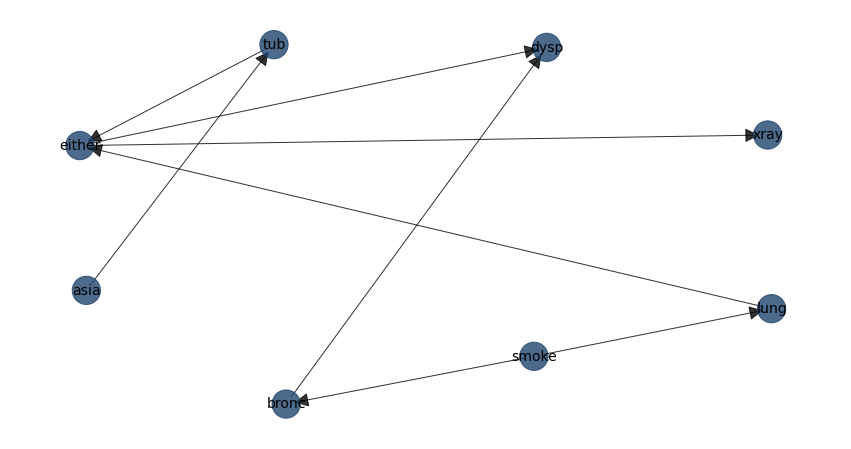

[bnlearn] >Forward sampling for 10000 samples..


Generating for node: dysp: 100%|██████████| 8/8 [00:00<00:00, 186.12it/s]

[bnlearn] >Computing best DAG using [hc]
[bnlearn] >Set scoring type at [bic]
[bnlearn] >Filter edges based on black_list/white_list


In [ ]:
DAG = bn.import_DAG('asia')
# plot ground truth
G = bn.plot(DAG)
# Sampling
df = bn.sampling(DAG, n=10000)
model_wl = bn.structure_learning.fit(df, methodtype='hc', white_list=['asia', 'tub', 'bronc', 'xray', 'smoke'], bw_list_method='edges')
# bn.plot(model_wl, pos=G['pos'])

# model_bl = bn.structure_learning.fit(df, methodtype='hc', black_list=['asia', 'tub'], bw_list_method='edges')
# bn.plot(model_bl, pos=G['pos'])
# Compare models
# bn.compare_networks(model_bl, model_wl, pos=G['pos'])

In [ ]:
# %% Adjust some edge properties

# Load asia DAG
df = bn.import_example(data='asia')
# Structure learning of sampled dataset
model = bn.structure_learning.fit(df)
# plot static
G = bn.plot(model)
# Compute associations with the chi_square test statistic
model = bn.independence_test(model, df)

# Set some edge properties
edge_properties = bn.get_edge_properties(model)
edge_properties['either', 'xray']['color']='#8A0707'
edge_properties['either', 'xray']['weight']=4
edge_properties['bronc', 'dysp']['weight']=10
edge_properties['bronc', 'dysp']['color']='#8A0707'

# Set some node properties
node_properties = bn.get_node_properties(model)
node_properties['xray']['node_color']='#8A0707'
node_properties['xray']['node_size']=20

# Plot
params_static={'edge_alpha': 0.6, 'arrowstyle': '->', 'arrowsize': 60}
bn.plot(model, interactive=False, node_properties=node_properties, edge_properties=edge_properties, params_static=params_static)

In [ ]:
# BNLEARN
model = bn.structure_learning.fit(df, methodtype='tan', class_node='DISPLACEM0', scoretype='bic')
model_bn = bn.parameter_learning.fit(model, df, methodtype='ml')  # maximum likelihood estimator
query=bn.inference.fit(model_bn, variables=['DISPLACEM0'], evidence={'RApp1': 1})

In [ ]:
df = bn.import_example('asia')
edges = [('smoke', 'lung'),
         ('smoke', 'bronc'),
         ('lung', 'xray'),
         ('bronc', 'xray')]

df = df[['smoke', 'lung', 'bronc', 'xray']]

print(df.head())

# Make the actual Bayesian DAG
DAG = bn.make_DAG(edges, verbose=0, methodtype='bayes')
model = bn.parameter_learning.fit(DAG, df, verbose=3)
# Generate some data based on DAG
df = bn.sampling(model, n=1000)
# Make predictions
Pout = bn.predict(model, df, variables=['bronc', 'xray'])

[bnlearn] >Extracting files..


Generating for node: dysp: 100%|██████████| 8/8 [00:00<00:00, 103.96it/s]


   smoke  lung  bronc  xray
0      1     1      1     1
1      1     1      1     1
2      1     1      1     1
3      0     1      0     1
4      0     1      0     1
[bnlearn] >Parameter learning> Computing parameters using [bayes]
[bnlearn] >CPD of smoke:
+----------+----------+
| smoke(0) | 0.494091 |
+----------+----------+
| smoke(1) | 0.505909 |
+----------+----------+
[bnlearn] >CPD of lung:
+---------+---------------------+---------------------+
| smoke   | smoke(0)            | smoke(1)            |
+---------+---------------------+---------------------+
| lung(0) | 0.14461821527138916 | 0.05211141060197664 |
+---------+---------------------+---------------------+
| lung(1) | 0.8553817847286108  | 0.9478885893980233  |
+---------+---------------------+---------------------+
[bnlearn] >CPD of bronc:
+----------+--------------------+--------------------+
| smoke    | smoke(0)           | smoke(1)           |
+----------+--------------------+--------------------+
| bronc(0) | 0.

Generating for node: xray: 100%|██████████| 4/4 [00:00<00:00, 329.33it/s]


[bnlearn]> Remaining columns for inference: 2


100%|██████████| 4/4 [00:00<00:00, 80.13it/s]
